['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5', 'ch_6', 'ch_7', 'ch_8', 'ch_9', 'ch_10', 'ch_11', 'ch_12', 'ch_13', 'ch_14', 'ch_15', 'ch_16', 'ch_17', 'ch_18', 'ch_19', 'ch_20', 'ch_21', 'ch_22', 'ch_23']


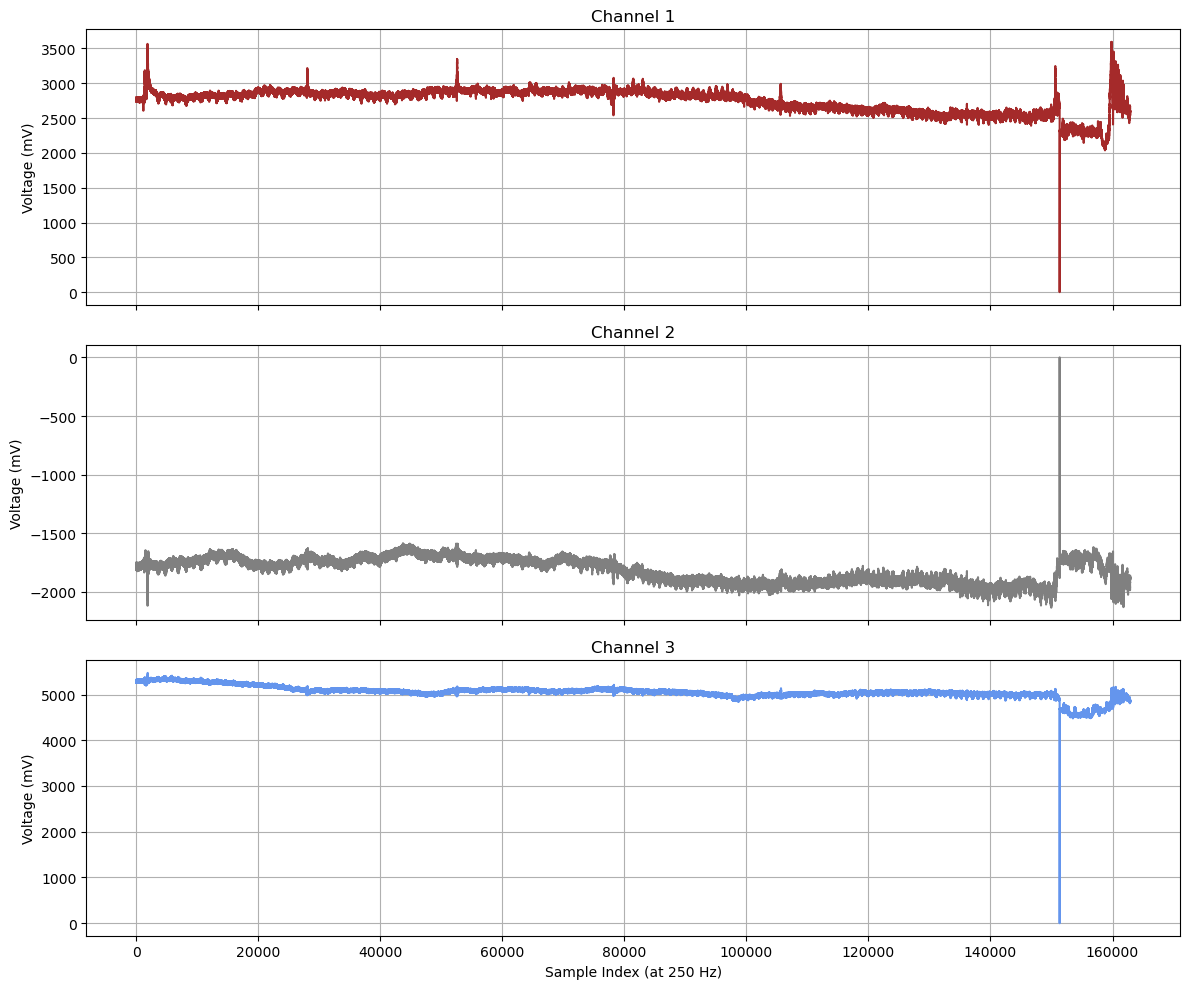

In [8]:
# -------------------------- Visualization of Raw data

import pandas as pd
import matplotlib.pyplot as plt

# Load OpenBCI data
path = "C:/Quick_Disk/tonge_emg_xr_project/data/Recordings3_right/recording3_right.csv"
df = pd.read_csv(path, sep='\t', skiprows=5, engine='python')

# Rename columns name for clarity
df.columns = [f"ch_{i}" for i in range(df.shape[1])]
print(df.columns.tolist())

# Define sampling rate and duration
sampling_rate = 250  # Hz
duration_sec = 20
num_samples = df.shape[0] # sampling_rate * duration_sec  # 5000 samples

# Create subplots
channel_colors = {
    'ch_1': 'brown',
    'ch_2': 'gray',
    'ch_3': '#6495ed'
}
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot Channel 1
axs[0].plot(df.iloc[:num_samples, 1], color=channel_colors['ch_1'])
axs[0].set_title("Channel 1")
axs[0].set_ylabel("Voltage (mV)")
axs[0].grid(True)

# Plot Channel 2
axs[1].plot(df.iloc[:num_samples, 2], color=channel_colors['ch_2'])
axs[1].set_title("Channel 2")
axs[1].set_ylabel("Voltage (mV)")
axs[1].grid(True)

# Plot Channel 3
axs[2].plot(df.iloc[:num_samples, 3], color=channel_colors['ch_3'])
axs[2].set_title("Channel 3")
axs[2].set_xlabel("Sample Index (at 250 Hz)")
axs[2].set_ylabel("Voltage (mV)")
axs[2].grid(True)

plt.tight_layout()
plt.show()


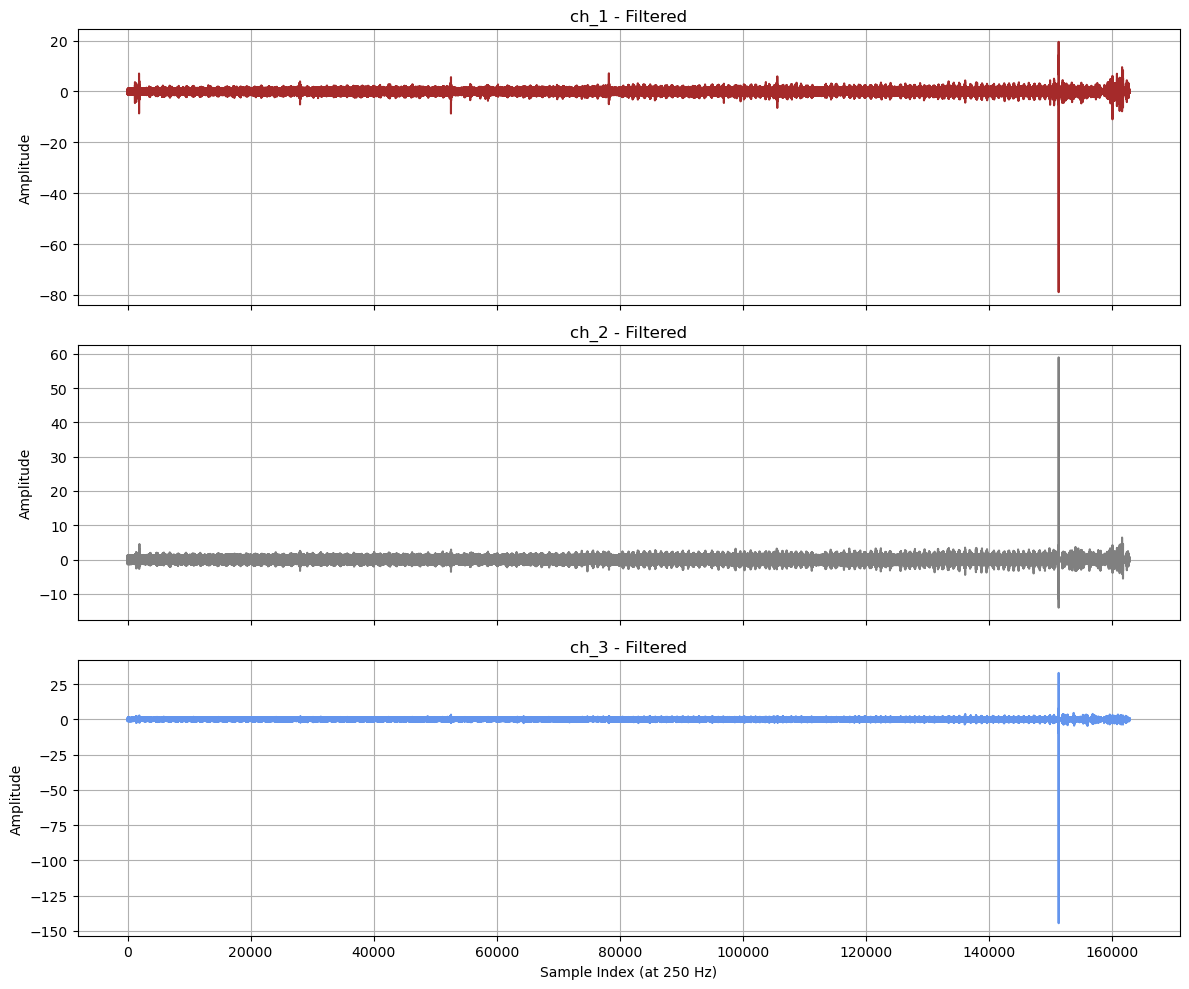

In [9]:
# -------------------------- Filtering

from scipy.signal import butter, filtfilt
import numpy as np

lowc = 20.0
highc = 120.0

def bandpass_filter(data, lowcut=lowc, highcut=highc, fs=250.0, order=4):
    nyq = 0.5 * fs  # 125 Hz
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def lowpass_filter(data, cutoff=5.0, fs=250.0, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

# Bandpass and Z-score
filtered = {}
for ch in ['ch_1', 'ch_2', 'ch_3']:
    # Bandpass
    raw_filtered = bandpass_filter(df[ch][:num_samples])
    
    # Z-score normalization
    mean = np.mean(raw_filtered)
    std = np.std(raw_filtered)
    zscored = (raw_filtered - mean) / std

    filtered[ch] = zscored

    # Full-wave rectification
    #rectified = np.abs(zscored)
    # Smoothing (low-pass filter)
    #smoothed = lowpass_filter(rectified)
    #filtered[ch] = smoothed

# Plot filtered signals
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

for i, ch in enumerate(['ch_1', 'ch_2', 'ch_3']):
    axs[i].plot(filtered[ch], label=f"{ch} (filtered)", color=channel_colors[ch])
    axs[i].set_title(f"{ch} - Filtered")
    axs[i].set_ylabel("Amplitude")
    axs[i].grid(True)

axs[2].set_xlabel("Sample Index (at 250 Hz)")
plt.tight_layout()
plt.show()


Annotations head
  class     timestamp
0   rci  1.749032e+09
1   rci  1.749032e+09
2   rci  1.749032e+09
3   rci  1.749032e+09
4   rci  1.749032e+09

EMG head
   ch_0         ch_1         ch_2         ch_3  ch_4  ch_5  ch_6  ch_7  ch_8  \
0   6.0  2757.177086 -1766.905399  5303.420759   0.0   0.0   0.0   0.0   0.0   
1   7.0  2788.447176 -1801.841176  5267.210933   0.0   0.0   0.0   0.0   0.0   
2   8.0  2788.290714 -1811.251260  5256.191523   0.0   0.0   0.0   0.0   0.0   
3   9.0  2753.466696 -1776.874277  5288.422738   0.0   0.0   0.0   0.0   0.0   
4  10.0  2736.993460 -1750.968605  5316.675343   0.0   0.0   0.0   0.0   0.0   

    ch_9  ...  ch_14  ch_15  ch_16  ch_17  ch_18  ch_19  ch_20  ch_21  \
0  0.020  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1  0.020  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2  0.018  ...  144.0  255.0  224.0  224.0   64.0    0.0    0.0    0.0   
3  0.018  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

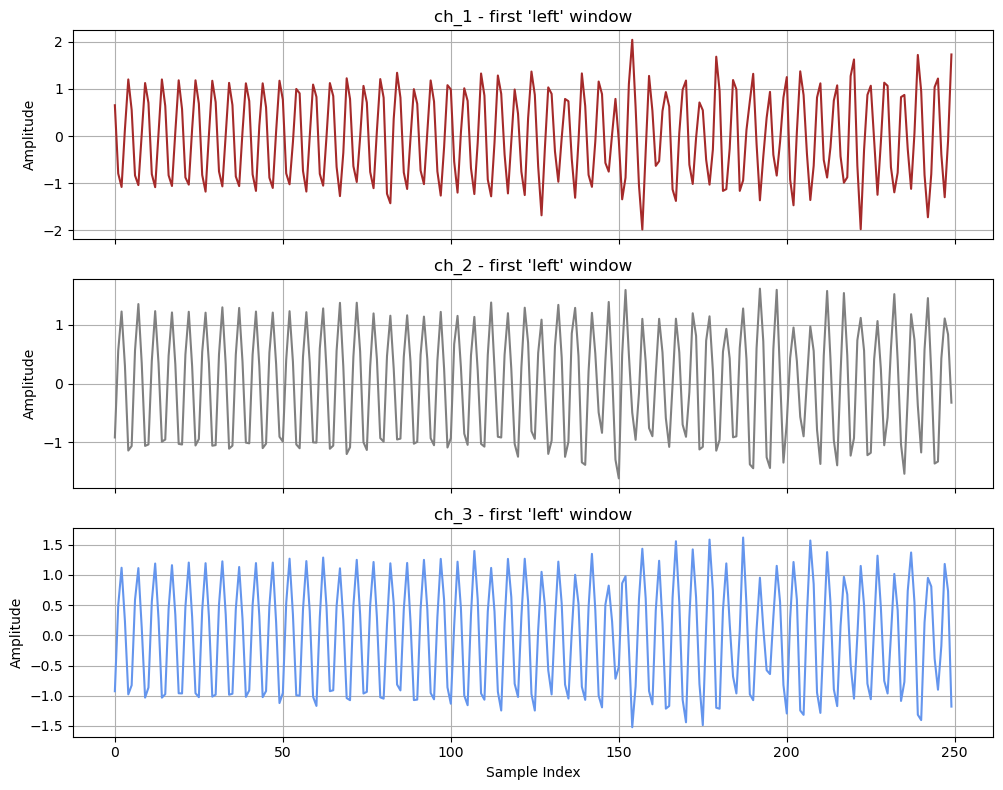

In [10]:
# -------------------------- Windows from the anotations timestamps

import pandas as pd
import numpy as np

# Get annotations
annotations_path = r"C:\Quick_Disk\tonge_emg_xr_project\scripts\data\annotations\annotations3_right.csv"
annotations = pd.read_csv(annotations_path, header=0, names=['class', 'timestamp'])

# Convert timestamp to numeric (float)
annotations['timestamp'] = pd.to_numeric(annotations['timestamp'], errors='coerce')

print("Annotations head")
print(annotations.head())
print("\nEMG head")
print(df.head())

# Get EMG data
# why is the timestamp in channel 22 ?? The official documentation says channel 13, anyway...
emg_timestamps = df['ch_22']  # Unix timestamps 

# Windows
window_size_seconds = 1
windowed_data = {'rci': [], 'rli': [], 'rc': [],'rp1': [],'rp2': [],'rm1': [],'rm2': []}  # Dictionary to hold windows by class

for idx, row in annotations.iterrows():
    label = row['class']     
    start_time = row['timestamp']
    end_time = start_time + window_size_seconds
    
    # Find indices of samples inside this window
    idxs = (emg_timestamps >= start_time) & (emg_timestamps < end_time)
    
    if not any(idxs):
        # No samples in this window, you can skip or log warning
        print(f"No data for window starting at {start_time} (label={label})")
        continue
    
    # Extract samples for each channel in this window
    window_ch1 = filtered['ch_1'][idxs]
    window_ch2 = filtered['ch_2'][idxs]
    window_ch3 = filtered['ch_3'][idxs]
    
    # Append to dictionary
    windowed_data[label].append({
        'ch_1': window_ch1,
        'ch_2': window_ch2,
        'ch_3': window_ch3,
        'start_time': start_time,
        'end_time': end_time
    })

# Check how many windows per class
print("\nHow many windows per class:")
for c in ['rci', 'rli', 'rc', 'rp1', 'rp2', 'rm1', 'rm2']:
    print(f"Class '{c}' windows: {len(windowed_data[c])}")

# Double check: how many samples in the first window, should be 250
first_window_l = windowed_data['rci'][0]
print("\nNumber of samples in first 'rci' window:")
print("ch_1:", len(first_window_l['ch_1']))
print("ch_2:", len(first_window_l['ch_2']))
print("ch_3:", len(first_window_l['ch_3']))

# Double check: print first window
first_l_window = windowed_data['rci'][0]
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i, ch in enumerate(['ch_1', 'ch_2', 'ch_3']):
    axs[i].plot(first_l_window[ch], color=channel_colors[ch])
    axs[i].set_title(f"{ch} - first 'left' window")
    axs[i].grid(True)
    axs[i].set_ylabel("Amplitude")
axs[-1].set_xlabel("Sample Index")
plt.tight_layout()
plt.show()


In [12]:
# -------------------------- Feature extraction

import numpy as np
import pandas as pd

#--------------Feature functions
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def zero_crossings(signal):
    signs = np.sign(signal)
    # Replace zeros with the previous sign or 1 (to avoid false zero crossings)
    for i in range(1, len(signs)):
        if signs[i] == 0:
            signs[i] = signs[i-1] if signs[i-1] != 0 else 1
    return np.sum(np.diff(signs) != 0)


def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal)))

def mav(signal): # mean absolute value
    return np.mean(np.abs(signal))

def ssc(signal, threshold=1e-3): # slope sign changes
    diff = np.diff(signal)
    return np.sum(((diff[1:] * diff[:-1]) < 0) & 
                  (np.abs(diff[1:] - diff[:-1]) > threshold))

def wamp(signal, threshold=1.1): # Number of times difference between samples > threshold
    return np.sum(np.abs(np.diff(signal)) > threshold)

def iemg(signal): # Integrated EMG (IEMG)	
    return np.sum(np.abs(signal))

# ----------------------------------

# Prepare lists to collect features and labels
features = []
labels = []

# Loop over all classes and windows
for label in ['rci', 'rli', 'rc', 'rp1', 'rp2', 'rm1', 'rm2']:
    for window in windowed_data[label]:
        # Extract channel signals
        ch1 = window['ch_1']
        ch2 = window['ch_2']
        ch3 = window['ch_3']
        
        # Compute features per channel
        feats = []
        for ch_signal in [ch1, ch2, ch3]:
            feats.append(rms(ch_signal))
            feats.append(zero_crossings(ch_signal))
            feats.append(waveform_length(ch_signal))
            # added features
            feats.append(mav(ch_signal))
            #feats.append(ssc(ch_signal))
            feats.append(wamp(ch_signal))
            feats.append(iemg(ch_signal))
        
        features.append(feats)
        labels.append(label)

# Create column names
#feature_names = ['RMS', 'ZC', 'WL', 'MAV', 'SSC', 'WAMP', 'IEMG']
#feature_names = ['RMS', 'ZC', 'WL']
feature_names = ['RMS', 'ZC', 'WL', 'MAV', 'WAMP', 'IEMG']

cols = []
for ch in ['ch_1', 'ch_2', 'ch_3']:
    for feat_name in feature_names:
        cols.append(f"{ch}_{feat_name}")


# Create DataFrame
X = pd.DataFrame(features, columns=cols)
y = pd.Series(labels, name='label')

print(X.head())
print(y.head())



   ch_1_RMS  ch_1_ZC     ch_1_WL  ch_1_MAV  ch_1_WAMP   ch_1_IEMG  ch_2_RMS  \
0  0.918649      100  236.777684  0.811711        104  202.927629  0.920983   
1  0.870304      100  218.779594  0.754193         92  188.548295  0.873513   
2  0.914067      100  237.270666  0.805503         97  201.375686  0.916371   
3  0.908797      100  236.229641  0.788820        101  197.204975  0.987186   
4  0.883108      100  232.833711  0.771159         94  192.789740  0.960576   

   ch_2_ZC     ch_2_WL  ch_2_MAV  ch_2_WAMP   ch_2_IEMG  ch_3_RMS  ch_3_ZC  \
0      100  237.292101  0.832496        106  208.124055  0.890694      100   
1      100  222.669173  0.772942         90  193.235524  0.878626      100   
2      100  240.049369  0.812150        123  203.037526  0.867379      100   
3       99  258.581033  0.869357        127  217.339328  0.863484       99   
4       99  246.823544  0.861544        118  215.385886  0.890940      100   

      ch_3_WL  ch_3_MAV  ch_3_WAMP   ch_3_IEMG  
0  231.

SVM Test accuracy: 0.45


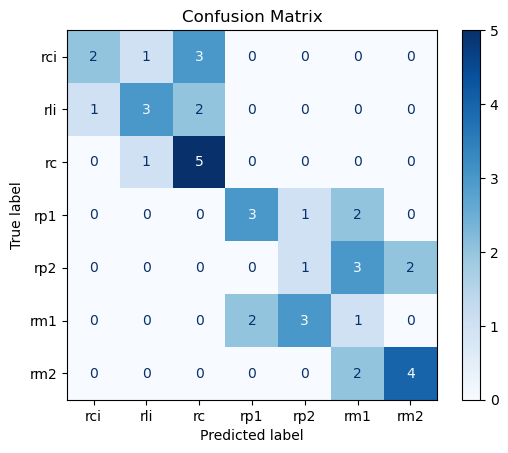

In [14]:
# -------------------------- Classification: SVM

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# 1. Split data (70% train, 30% test), X = features, y = labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# 2. Train clf (classifier)
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

# 3. Predict 
y_pred = clf.predict(X_test)

# 4. Evaluate 
acc = accuracy_score(y_test, y_pred)
print(f"SVM Test accuracy: {acc:.2f}")

# 5. Confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=['rci', 'rli', 'rc', 'rp1', 'rp2', 'rm1', 'rm2'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['rci', 'rli', 'rc', 'rp1', 'rp2', 'rm1', 'rm2'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



Radom Forest Test Accuracy: 0.43


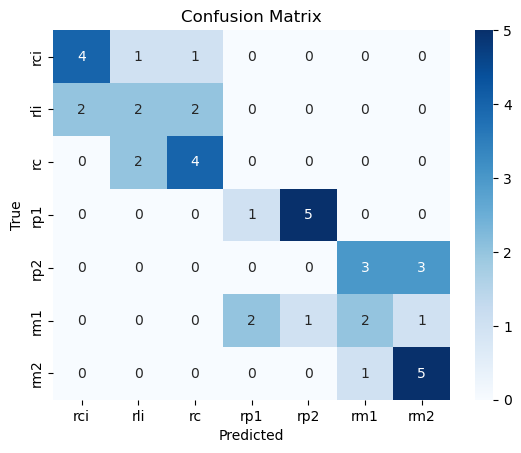

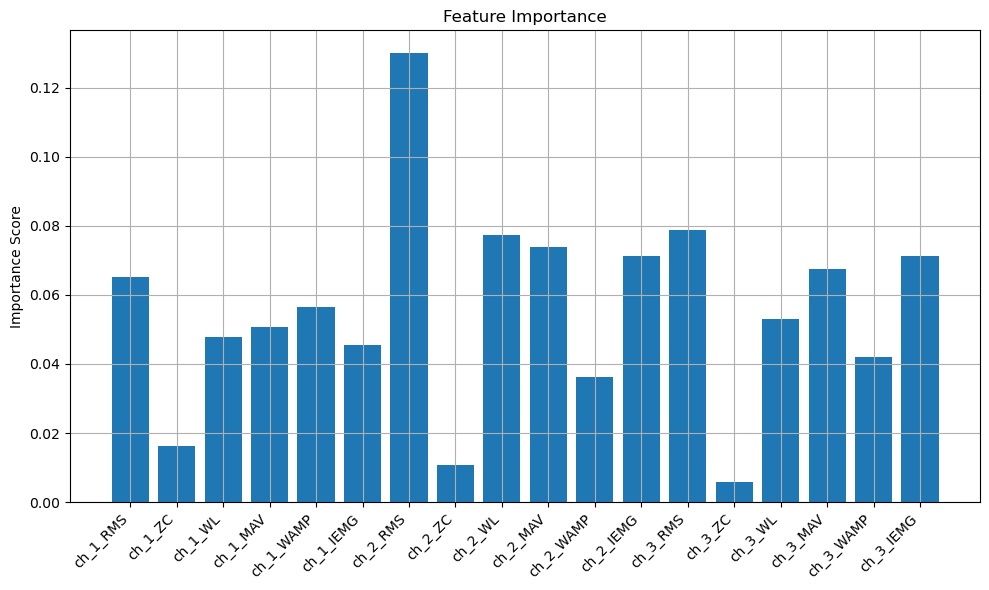

In [16]:
# -------------------------- Classification: Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Train 
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 3. Predict
y_pred = clf.predict(X_test)

# 4. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['rci', 'rli', 'rc', 'rp1', 'rp2', 'rm1', 'rm2'])

print(f"Radom Forest Test Accuracy: {acc:.2f}")

# 5. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['rci', 'rli', 'rc', 'rp1', 'rp2', 'rm1', 'rm2'], yticklabels=['rci', 'rli', 'rc', 'rp1', 'rp2', 'rm1', 'rm2'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 6. Plot feature importance
importances = clf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()